In [3]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from sklearn.externals.joblib import Parallel, delayed
from skimage.restoration import denoise_nl_means,estimate_sigma
from scipy import signal
from joblib import Parallel, delayed
import os
import h5py
from numba import cuda,float32,uint16,float64  
import time
import pickle
#from sel_active_reg_gen import sel_active_reg






In [3]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import cv2
from sklearn.externals.joblib import Parallel, delayed
from skimage.restoration import denoise_nl_means,estimate_sigma
from scipy import signal
from joblib import Parallel, delayed
import os
import h5py
from numba import cuda,float32,uint16,float64,int64,int32
import time
from math import floor

import torch


@cuda.jit
def sel_active_gpu_gen(bz,time_ref,per_mat,stack,im_out,cover,BPM_ratio,stp,iter_block,last_stp,debug=False):
    
   
    size = cuda.gridDim.x
    iterat = int32(iter_block//(size//BPM_ratio))
    if iter_block%(size//BPM_ratio)>0:
        iterat+=1
        
    b_dimx = cuda.blockDim.x
    b_dimy = cuda.blockDim.y
    stp_iter = stp*(size//BPM_ratio)
    
    bx = cuda.blockIdx.x 
    by = cuda.blockIdx.y
            
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    if bx*b_dimx+bx+tx == 0 and by*b_dimx+by+ty==0 and debug==True:
        #from pdb import set_trace; set_trace()
        print('check',size//BPM_ratio)
        print(iterat)
        

    
    for it in range(int32(iterat*iterat)):
        it_bk =int32(it//iterat)
        it_bk_y = int32(it%iterat)
        if it_bk*stp_iter+((bx//BPM_ratio)*stp)<=last_stp and it_bk_y*stp_iter+((by//BPM_ratio)*stp)<=last_stp:
                
            if stack[bz,it_bk*stp_iter+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*stp_iter+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty] >= per_mat[bz+time_ref,it_bk*(size//BPM_ratio)+bx//BPM_ratio,it_bk_y*(size//BPM_ratio)+by//BPM_ratio]:
                cuda.atomic.add(im_out,(it_bk*stp_iter+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*stp_iter+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)

            if bz ==0 and time_ref==0:
                cuda.atomic.add(cover,(it_bk*stp_iter+(bx//BPM_ratio)*stp+(bx%BPM_ratio)*b_dimx+tx,it_bk_y*stp_iter+(by//BPM_ratio)*stp+(by%BPM_ratio)*b_dimy+ty),1)
    
    
class sel_active_reg():
    
    def __init__(self,stack,dict_params,verbose=True,static=False):
        self.stack = stack
        self.step_list = dict_params['list']
        if len(self.step_list)==1:
            self.stp=1
        else:
            self.stp = self.step_list[1]-self.step_list[0]
        self.blocks = dict_params['blocks']
        self.threads = dict_params['threads']
        self.BPM_ratio = dict_params['BPM_ratio'] # # of block inside a patch
        self.bb = dict_params['bb']

        self.N_pix_st = dict_params['N_pix_st']
        self.astr_min = dict_params['astr_min']
        self.per_tile = dict_params['percentile']
        self.astro_num = dict_params['astro_num']
        self.init_th_ = dict_params['init_th_']
        self.decr_dim = dict_params['decr_dim']
        self.decr_th = dict_params['decr_th']
        self.corr_int = dict_params['corr_int']
        self.gpu_flag = dict_params['gpu_flag']
        self.jobs = -1
        self.static = static
        self.verbose = verbose
        self.iter_block = len(dict_params['list'])
        self.gpu_num = 0
    
    def check_sel_active_reg_gpu_gen(self,void_out=True,debug=True):

        _,N,M = self.stack.shape
        T=1
        cuda.select_device(self.gpu_num)    

        threadsperblock = (self.threads,self.threads)
        blockspergrid = (self.blocks,self.blocks)
             
        ### allocate percentile matrix
        
        if self.verbose: print('GPU started with ',blockspergrid,' blocks and ', threadsperblock,' threads per block')
        if self.verbose: print('Iteration per block: ',int(self.iter_block/(self.blocks//self.BPM_ratio)))
        
        mat_per = np.zeros((1,len(self.step_list),len(self.step_list)),dtype=np.int32)
        mat_per_g = cuda.to_device(mat_per) 
        ### allocate in ram
        im_out = np.zeros((N,M),dtype=np.int32)
        cover = np.zeros((N,M),dtype=np.int32)
        ### allocate and load in DRAM
        im_out_g = cuda.to_device(im_out)
        cover_g = cuda.to_device(cover)

        blocks_to_load =[i*1000 for i in range((T//1000)+1)]
        blocks_to_load.append(T)
       
        for stps in range(len(blocks_to_load)-1):
            stack_gpu = cuda.to_device(self.stack[blocks_to_load[stps]:blocks_to_load[stps+1],:,:])
            
            for bz in range(blocks_to_load[stps+1]-blocks_to_load[stps]):
                print('debug',debug)
                sel_active_gpu_gen[blockspergrid, threadsperblock](bz,blocks_to_load[stps],mat_per_g,stack_gpu,im_out_g,cover_g,self.BPM_ratio,self.stp,self.iter_block,self.step_list[-1],debug)#
                
            ### free from old stack
            del stack_gpu
        
        print('OUT shape',cover_g.shape)
        im_out = im_out_g.copy_to_host()
        cover = cover_g.copy_to_host()
#         assert cover.min()!=0, 'Check steps positions and BB'
#         assert (im_out/cover).max()==1,'Check steps positions,BB and input stack, MAX val too much high'
        if void_out:
            pass
        else:
            return im_out,cover
    
# with open('/media/DATA/jbonato/astro_segm/set7/.tmp/dict_dataset1.txt', "rb") as fp:   
#     dict_param = pickle.load(fp)

# dict_param['list'] = [i*40 for i in range(12)]
# dict_param

dict_param = {
    'list':[i*33 for i in range(45)],
    'blocks':17*2,
    'threads':24,
    'BPM_ratio':2,
    'bb':48,
    'N_pix_st':50, #starting minimum area
    'astr_min':100,#100
    'percentile': 80,#80
    'pad':0,
    'astro_num':150, # number of astro min in FOV ####150 but for 1170 is 100 # 300 for fov 0020 5
    'init_th_':0.5, #.3 for 1170 ,.5 threshold initialization approx. 125
    'decr_dim':5, # astro area decrease
    'decr_th':25, # temporal threshold decrease
    'corr_int':True, # intensity correction flag
    'gpu_flag':True
}

dict_param['percentile']=80
dict_param['max_min'] = np.asarray([345,89])
max_min = dict_param['max_min']

dict_param['th1_p']=0.20
dict_param['th2_p']=0.08



GPU started with  (34, 34)  blocks and  (24, 24)  threads per block
Iteration per block:  2
debug True
OUT shape (1500, 1500)


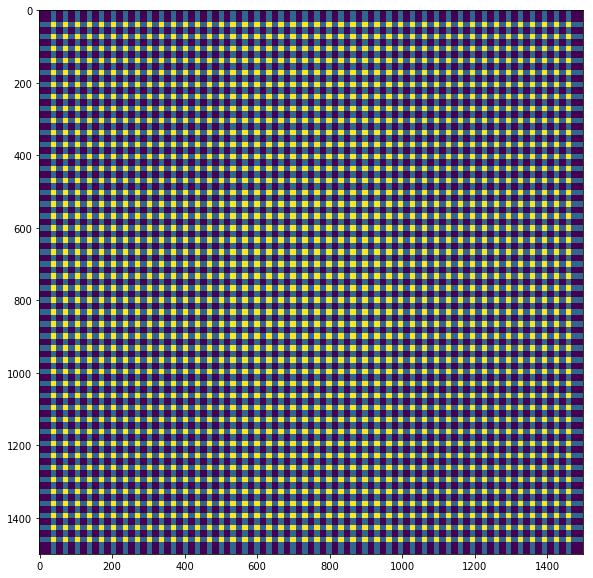

In [4]:
stack = np.zeros((10,1500,1500))

a_reg = sel_active_reg(stack.astype(np.float32),dict_param)

A,B = a_reg.check_sel_active_reg_gpu_gen(void_out=False,debug=True)

plt.figure(figsize=(10,10))
plt.imshow(B)
# plt.savefig('testS.png')

In [5]:
B.min()

1

In [3]:
# with open('/media/DATA/jbonato/astro_segm/set7/.tmp/dict_dataset1.txt', "rb") as fp:   
#     dict_param = pickle.load(fp)

# dict_param['list'] = [i*40 for i in range(12)]
# dict_param


# dict_param['blocks']=15
# dict_param['threads']=24
# dict_param['BPM_ratio']=4
# dict_param['N_pix_st']=50
# dict_param['astr_min']=50
# dict_param['th1_p']=.25
# dict_param['th2_p']=.1
# dict_param['max_min']=np.asarray([345,60])
# dict_param['astro_num']=40
# dict_param['bb']=80
# dict_param['pad']=8
# dict_param['list']=[i*54 for i in range(9)]
# dict_param['list'][-1]=432
# dict_param['decr_dim'] = 5
# dict_param['init_th'] = 0.5
# dict_param['decr_th'] = 7.333333333333333*25

# with open('/media/DATA/jbonato/astro_segm/set4/.tmp/dict_dataset.txt', "rb") as fp:   #Pickling
#     dict_param = pickle.load(fp)
# dict_param['init_th_'] = 0.5

# dict_param['BPM_ratio']=3
# dict_param['blocks']= 15
# dict_param['threads']=32

# dict_param = {
#     'list':[i*40 for i in range(12)],
#     'blocks':8,
#     'threads':12,
#     'BPM_ratio':8,
#     'bb':96,
    
#     'N_pix_st':100, #starting minimum area
#     'astr_min':80, # approx. 0.9 min in dataset
#     'percentile': 80,
#     'pad':5,
#     'astro_num':4, # number of astro min in FOV
#     'init_th_':0.6, # threshold initialization
#     'decr_dim':10, # astro area decrease
#     'decr_th':25, # temporal threshold decrease
#     'corr_int':False, # intensity correction flag
#     'gpu_flag':True
# }

dict_param = {
    'list':[i*33 for i in range(45)],
    'blocks':17*2,
    'threads':24,
    'BPM_ratio':2,
    'bb':48,
    'N_pix_st':50, #starting minimum area
    'astr_min':100,#100
    'percentile': 80,#80
    'pad':0,
    'astro_num':150, # number of astro min in FOV ####150 but for 1170 is 100 # 300 for fov 0020 5
    'init_th_':0.5, #.3 for 1170 ,.5 threshold initialization approx. 125
    'decr_dim':5, # astro area decrease
    'decr_th':25, # temporal threshold decrease
    'corr_int':True, # intensity correction flag
    'gpu_flag':True
}

dict_param['percentile']=80
dict_param['max_min'] = np.asarray([345,89])
max_min = dict_param['max_min']

dict_param['th1_p']=0.20
dict_param['th2_p']=0.08


In [ ]:
stack = np.zeros((600,1500,1500))

a_reg = sel_active_reg(stack.astype(np.float32),dict_param)

A,B = a_reg.check_sel_active_reg_gpu_gen(void_out=False,debug=True)

GPU started with  (34, 34)  blocks and  (24, 24)  threads per block
Iteration per block:  2.6470588235294117
debug True
(1500, 1500)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(B)

In [8]:
B[:,:96].min()
np.unique(B)

array([1, 2, 3, 4, 5, 6, 9], dtype=int32)

In [9]:
B.max()

9